In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel


In [2]:
# the gaussian is defined for fuzzification of input variables
def gaussian(inp,mean,var):
    std=np.sqrt(var)
    value=(1/(np.sqrt(2*np.pi*var)))*np.exp((-1*(mean-inp)**2)/(2*var))
    return value

In [3]:
#the membership values for each input is defined using the gaussian defined above. here it is categorised under High, Medium, Low
def membership(inp,mean_l,mean_m,mean_h,var=0.8):#l,h are the base width of the right triangle.m is the half base width of the isoceles
    ul,um,uh=0,0,0
    ul=gaussian(inp,mean_l,var)
    um=gaussian(inp,mean_m,var)
    uh=gaussian(inp,mean_h,var)
    ULMH=np.array([[ul,um,uh]])
    return ULMH.reshape(1,3) # matrix of dimensions 1,3

In [4]:
def relu(out):
    if out>0:
        return out
    else:
        return 0.1*out # leaky relu 

In [5]:
#fuzzy node is defined. Forward and back prop to this node is defined
class node():
    
    def __init__(self):
        self.LMH=np.random.uniform(0,300, (2,3))# generates 2*3 matrix of random numbers between 0 to 0.5
        self.ab=np.random.randint(1,4,(9,2))#9*2 matrix of random numbers between 1 to 4 excludiing 4
        self.LMH_update=np.zeros((2,3))#update gonna be used during backprop
        self.ab_update=np.zeros((9,2))#update gonna be used during backprop
        self.LMH[0][0]=0
        self.LMH[0][1]=0.5
        self.LMH[0][2]=1
        self.LMH[1][0]=0
        self.LMH[1][1]=0.5
        self.LMH[1][2]=1
    def membership_class(self,inp1,inp2):
        self.inp1=inp1
        self.inp2=inp2
        self.U1=membership(self.inp1,self.LMH[0][0],self.LMH[0][1],self.LMH[0][2])# matrix of dimensions 1,3
        self.U2=membership(self.inp2,self.LMH[1][0],self.LMH[1][1],self.LMH[1][2])# matrix of dimensions 1,3   
        
        
    def membership_class_node1(self,inp1,inp2):
        self.inp1=inp1
        self.inp2=inp2
        self.LMH[0][0]=20
        self.LMH[0][1]=140
        self.LMH[0][2]=260
        self.LMH[1][0]=0
        self.LMH[1][1]=0.5
        self.LMH[1][2]=1
        self.U1=membership(self.inp1,self.LMH[0][0],self.LMH[0][1],self.LMH[0][2],var=1000)# matrix of dimensions 1,3
        self.U2=membership(self.inp2,self.LMH[1][0],self.LMH[1][1],self.LMH[1][2])# matrix of dimensions 1,3       
        
    def forward_prop(self):
        self.inp=np.array([[self.inp1],[self.inp2]])
        #print(self.inp)
        self.inp=self.inp.reshape(2,1) #matrix of dimensions 2*1
        
        self.k=np.dot(self.U1.T,self.U2)#k is a 3*3 matrix
        
        self.ksum=np.sum(self.k)
        self.ksum=float(self.ksum)
        if self.ksum==0:
            self.ksum=1
            
        self.k_norm=self.k/self.ksum #k_norm is normalised
        
        self.w=self.k_norm.reshape(1,9)#self is a matrix of dimensions 1*9
        
        self.y=np.dot(self.ab,self.inp) #y is a matrix of dimensions 9*1
        
        self.out_before_relu=np.dot(self.w,self.y) #out is a matrix of dimension 1*1
        
        self.out_before_relu=float(self.out_before_relu)# typecasts matrix of size 1*1 to float
        
        self.out=relu(self.out_before_relu)# relu activation function is used
        #print('LMH',self.LMH)
    
    def backprop_to_prev_node (self,learning_rate,last):
        if self.out_before_relu>0:
            self.relu_drvt=1
        else:
            self.relu_drvt=0.1 # derivative of relu
            
        self.to_prev=learning_rate*last*self.relu_drvt*(np.sum(self.ab[:,0]*self.w.T)) 
        
        self.to_prev=float(self.to_prev)
        
        
        
        
    def backprop_ab(self,learning_rate,last):
        self.ab_update=self.ab_update+learning_rate*last*self.relu_drvt*self.w.reshape(9,1)*self.inp.T
        
        
        
        
    def backprop_LMH(self,learning_rate,last,var=0.8): # backprop with gaussian membership function. var is variance of gaussian
        
        self.d=(self.ksum-self.k)/(self.ksum*self.ksum) # d is a 3*3 matrix
        
        self.dummy=self.y.reshape(3,3)*self.d*self.k #3*3 matrix
        
        self.dummy1=self.dummy.sum(axis=1)# sums along rows. 3*1 matrix
        self.dummy2=self.dummy.sum(axis=0)# sums along columns . 1*3 matrix
        
        self.drvt=(self.LMH-self.inp)/(2*np.sqrt(var)) # LMH is 2*3 inp is 2*1 drvt is 2*3 matrix 
        
        self.dummy1=self.dummy1.T*self.drvt[0,:] # dummy1.T is 1*3 drvt[0,:] is 1*3 dummy1 is 1*3 
        self.dummy2=self.dummy2*self.drvt[1,:] # dummy2 is 1*3 drvt[1,:] is 1*3 dummy2 is 1*3 
        
        self.LMH_update[0,:]=self.LMH_update[0,:]+learning_rate*last*self.relu_drvt*self.dummy1 # 1*3 
        self.LMH_update[1,:]=self.LMH_update[1,:]+learning_rate*last*self.relu_drvt*self.dummy2 # 1*3 
        
        
        
    def update(self):
        self.ab=self.ab+self.ab_update
        self.LMH=self.LMH+self.LMH_update
        
    def reset(self):
        self.LMH_update=np.zeros((2,3))
        self.ab_update=np.zeros((9,2))
        
        

In [6]:
#a normal node( or a layer of nodes) is defined with forward and back prop algorithms
class layer():
    def __init__(self):
        self.a=0
            
            
    def initalise(self,n,n_inp): # n is the number of nodes in a layer. n_inp are the number of inputs to that node.
        self.n=n
        self.n_inp=n_inp
        self.weights=np.random.uniform(-1,1, (n_inp,n))#random numbers between -1 to 1 generated, n_inp*n matrix
        self.bias=np.random.uniform(-1,1, (1,n))# 1*n matrix
        self.activate=np.zeros((1,n))
        self.d_activation_relu=np.zeros((1,n))
    
    def forwardpass(self,inp) :
        self.inp=inp
        self.forward=np.dot(self.inp,self.weights)+self.bias
        
        for i in range(self.n):
            self.activate[0][i]=relu(self.forward[0][i])
            
    def drv_activation_relu(self):
        for i in range(self.n):
            if self.activate[0][i] >=0:
                self.d_activation_relu[0][i]=1
            else:
                self.d_activation_relu[0][i]=-0.1
                
                
    def to_prev_layer(self,from_next,d_act_pre):# from_next is output from neurons ahead to this layer (backprop)
        self.from_next=from_next# n*1  #d_act_pre is the derivative of the activation of the previous neuron
        self.d_act_pre=d_act_pre #1*n
        
        
        self.w_pre=np.dot(self.weights,self.from_next*self.d_act_pre.reshape(self.n,1))# n_inp*1
        self.to_pre=self.w_pre #n_inp*1


    def to_prev_layer1(self,from_next,d_act_pre):# from_next is output from neurons ahead to this layer (backprop)
        self.from_next=from_next# n*1  #d_act_pre is the derivative of the activation of the previous neuron
        self.d_act_pre=d_act_pre #1*n_inp
        self.w_pre=self.weights*self.from_next*self.d_act_pre# n_inp*1
        self.to_pre=self.w_pre #n_inp*1     
        
     
    
    def backprop_weights(self,lr,from_next,d_act_pre): #d_act_pre is 1*n, self.inp is 1*n_inp,from_next is n*1
        self.update_weights=np.zeros((self.n_inp,self.n)) #n_inp*n
        self.update_bias=np.zeros((1,self.n)) # 1*n
        self.dummy_weights=np.ones((self.n_inp,self.n)) #n_inp*n
        self.dummy_bias=np.ones((1,self.n)) #1*n
        
        self.update_weights=self.update_weights+lr*(self.dummy_weights*self.inp.reshape(self.n_inp,1))*from_next.reshape(1,self.n)*d_act_pre
        self.update_bias=self.update_bias+lr*self.dummy_bias*d_act_pre*from_next.reshape(1,self.n)
        
    def backprop_weights1(self,lr,from_next,d_act_pre): #d_act_pre is 1*n, self.inp is 1*n_inp,from_next is n*1
        self.update_weights=np.zeros((self.n_inp,self.n)) #n_inp*n
        self.update_bias=np.zeros((1,self.n)) # 1*n
        self.dummy_weights=np.ones((self.n_inp,self.n)) #n_inp*n
        self.dummy_bias=np.ones((1,self.n)) #1*n
        
        self.update_weights=self.update_weights+lr*(self.dummy_weights*self.inp.reshape(self.n_inp,1))*from_next*d_act_pre
        self.update_bias=self.update_bias+lr*self.dummy_bias*d_act_pre*from_next
        
    def update(self):
        self.weights=self.weights+self.update_weights
        self.bias=self.bias+self.update_bias
    
    
  
        

In [7]:
#training data is initalised
df = pd.read_csv("train_FD001.txt", sep=" ",header=None)
train=df
train.drop([26,27],axis=1,inplace=True) #drop columns as both of them contain NaN values
train.drop([4,5,9,10,14,20,22,23],axis=1,inplace=True) # columns with constant values
train.columns=['ID','Cycles','OS1','OS2','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']
EOL=[]
for i in train['ID']:
        EOL.append( ((train[train['ID'] == i]["Cycles"]).values)[-1])
train["EOL"]=EOL
train["RULf"] = train["Cycles"].div(train["EOL"])
train=train.drop(columns=['ID','EOL'])

In [8]:
# training data is normalised
to_be_normalised=train[['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']]
data_min=to_be_normalised.min()
data_max=to_be_normalised.max()
data_min=data_min.to_numpy()#converting pandas to numpy array of dimension 14*1
data_max=data_max.to_numpy()
data_min=np.reshape(data_min,(1,14))#reshaping 14*1 to 1*14
data_max=np.reshape(data_max,(1,14))
normalised=(to_be_normalised-to_be_normalised.min())/(to_be_normalised.max()-to_be_normalised.min())


In [9]:
train[['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']]=normalised[['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']]
train["Cycles"]=train["Cycles"]/500
train = train.sample(frac=1).reset_index(drop=True)
target = train.pop('RULf')
train_matrix=train.to_numpy()
tar=target.to_numpy()


In [10]:
#nodes and layers are initalised 
node1=node()
node2=node()
node3=node()
node4=node()
node5=node()
node6=node()
node7=node()
layer1=layer()
layer2=layer()
layer3=layer()

In [11]:

train_matrix.shape

(20631, 17)

In [12]:
#dimension of the neural network is defined
layer1.initalise(8,10) #O/P,I/P
layer2.initalise(6,8)
layer3.initalise(1,6)

In [437]:
#forward and back prop in action
b=np.zeros((1,10))
mse=0
cycle=np.zeros((20631,1))
Yout=np.zeros((20631,1))
Yerr=np.zeros((20631,1))
lr=0.01
for i in range(0,4126):
    for j in range(0,5):
        inp=train_matrix[i*5+j]
        cycle[i*5+j]=i*5+j
    
        #print(i*10+j)
        node1.membership_class(inp[3],inp[4])
        node1.forward_prop()
        node2.membership_class(inp[5],inp[6])
        node2.forward_prop()
        node3.membership_class(inp[7],inp[8])
        node3.forward_prop()
        node4.membership_class(inp[9],inp[10])
        node4.forward_prop()
        node5.membership_class(inp[11],inp[12])
        node5.forward_prop()
        node6.membership_class(inp[13],inp[14])
        node6.forward_prop()
        node7.membership_class(inp[15],inp[16])
        node7.forward_prop()
        
        b=np.array([[inp[0],inp[1],inp[2],node1.out,node2.out,node3.out,node4.out,node5.out,node6.out,node7.out]])
        
        
      
        layer1.forwardpass(b)
        layer2.forwardpass(layer1.activate)
        layer3.forwardpass(layer2.activate)
        #print(layer1.activate)
        
        Yout[i*5+j]=float(layer3.forward)
        Yerr[i*5+j]=(float(layer3.forward)-tar[i*5+j])**2
        
        layer1.drv_activation_relu()
        layer2.drv_activation_relu()
        layer3.drv_activation_relu
        
        
        err=2*(tar[i*5+j]-float(layer3.forward))
        
        z=np.array([[1]])
   
        layer3.to_prev_layer1(err,1)
        layer3.backprop_weights1(lr,err,1)
        
        layer2.to_prev_layer(layer3.to_pre,layer2.d_activation_relu)
        layer2.backprop_weights(lr,layer3.to_pre,layer2.d_activation_relu)
        
        
        layer1.to_prev_layer(layer2.to_pre,layer1.d_activation_relu)
        layer1.backprop_weights(lr,layer2.to_pre,layer1.d_activation_relu)
        
        
        #print(layer1.to_pre)
        node1.backprop_to_prev_node(lr,layer1.to_pre[3][0])
        node1.backprop_ab(lr,layer1.to_pre[3][0])
        node1.backprop_LMH(lr,layer1.to_pre[3][0])
        
        
        node2.backprop_to_prev_node(lr,layer1.to_pre[4][0])
        node2.backprop_ab(lr,layer1.to_pre[4][0])
        node2.backprop_LMH(lr,layer1.to_pre[4][0])
        
        
        node3.backprop_to_prev_node(lr,layer1.to_pre[5][0])
        node3.backprop_ab(lr,layer1.to_pre[5][0])
        node3.backprop_LMH(lr,layer1.to_pre[5][0])
        
        node4.backprop_to_prev_node(lr,layer1.to_pre[6][0])
        node4.backprop_ab(lr,layer1.to_pre[6][0])
        node4.backprop_LMH(lr,layer1.to_pre[6][0])
        
        node5.backprop_to_prev_node(lr,layer1.to_pre[7][0])
        node5.backprop_ab(lr,layer1.to_pre[7][0])
        node5.backprop_LMH(lr,layer1.to_pre[7][0])
        
        node6.backprop_to_prev_node(lr,layer1.to_pre[8][0])
        node6.backprop_ab(lr,layer1.to_pre[8][0])
        node6.backprop_LMH(lr,layer1.to_pre[8][0])
        
        node7.backprop_to_prev_node(lr,layer1.to_pre[9][0])
        node7.backprop_ab(lr,layer1.to_pre[9][0])
        node7.backprop_LMH(lr,layer1.to_pre[9][0])
        
        #print("out", layer3.forward,"tar",tar[i*10+j],"error",tar[i*10+j]-layer3.forward)
       # print(layer1.to_pre.shape)
        #print(layer2.to_pre.shape)
        
        mse=mse+(tar[i*5+j]-layer3.forward)**2
        layer3.update()
        layer2.update()
        layer1.update()
        node1.update()
        node1.reset()
        node2.update()
        node2.reset()
        node3.update()
        node3.reset()
        node4.update()
        node4.reset()
        node5.update()
        node5.reset()
        node6.update()
        node6.reset()
        node7.update()
        node7.reset()
        

        

In [438]:
#mean square error
print(mse)
print(mse/20630) #all input variables present+ 2 hidden layers

[[89.63077707]]
[[0.00434468]]


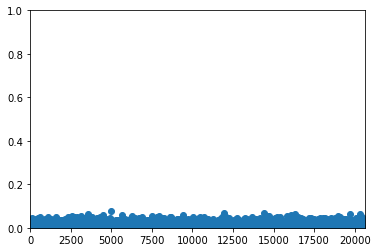

In [439]:
plt.axis([0,20630 , 0, 1])
plt.scatter(cycle,Yerr)
plt.show()

In [440]:
print("lmh1",node1.LMH)

lmh1 [[0.1519869  0.60643486 0.9780776 ]
 [0.10978888 0.51777376 0.91765972]]


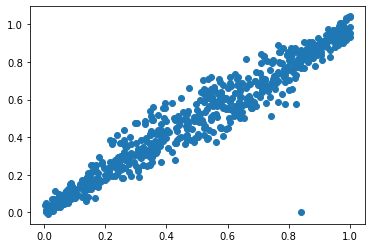

In [441]:
#target value vs predicted value
plt.scatter(tar[20000:],Yout[20000:])
plt.show()

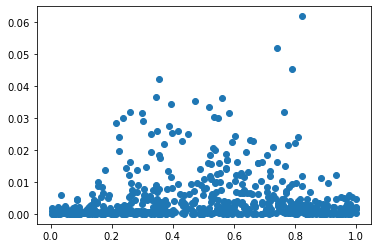

In [442]:
plt.scatter(tar[20000:],Yerr[20000:])
plt.show()

In [443]:
#test data is initalised
df1 = pd.read_csv("test_FD001.txt", sep=" ",header=None)
test=df1
test.drop([26,27],axis=1,inplace=True) #drop columns as both of them contain NaN values
test.drop([4,5,9,10,14,20,22,23],axis=1,inplace=True) # columns with constant values
test.columns=['ID','Cycles','OS1','OS2','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']

In [444]:
#test data is normalised
to_be_normalised1=test[['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']]

#min max normalisation
normalised1=(to_be_normalised1-data_min)/(data_max-data_min)
test[['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']]=normalised1[['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']]
test["Cycles"]=test["Cycles"]/500

In [445]:
#function predicts the output till truncation
def pred_test(a):
    b=np.zeros((1,10))
    test_pred=test.loc[test['ID'] == a]
    inp_test_pred=test_pred[['Cycles','OS1','OS2','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']]
    test_matrix=inp_test_pred.to_numpy()
    Y_pred=[0]*len(test_matrix)
    for j in range(0,len(test_matrix)):
        inp=test_matrix[j]
        #print(test_matrix[j])
        #print(j)
        node1.membership_class(inp[3],inp[4])
        node1.forward_prop()
        node2.membership_class(inp[5],inp[6])
        node2.forward_prop()
        node3.membership_class(inp[7],inp[8])
        node3.forward_prop()
        node4.membership_class(inp[9],inp[10])
        node4.forward_prop()
        node5.membership_class(inp[11],inp[12])
        node5.forward_prop()
        node6.membership_class(inp[13],inp[14])
        node6.forward_prop()
        node7.membership_class(inp[15],inp[16])
        node7.forward_prop()
        
        b=np.array([[inp[0],inp[1],inp[2],node1.out,node2.out,node3.out,node4.out,node5.out,node6.out,node7.out]])
        
        
      
        layer1.forwardpass(b)
        layer2.forwardpass(layer1.activate)
        layer3.forwardpass(layer2.activate)
        #Y_pred[j]=float(1-layer3.forward)
        Y_pred[j]=float(layer3.forward)
        #Y_pred=1-np.array(Y_pred)
        #Y_pred=np.array(Y_pred)
        #print(Y_pred.shape)
        #print(Y_pred)
    
    
    #plt.plot(test_pred['Cycles']*500,Y_pred,c='red')
    #plt.show()
    Y_pred=np.array(Y_pred)
    #print(Y_pred)
    

    return Y_pred ,test_pred['Cycles'].to_numpy().reshape(-1,1)*500,test_pred['Cycles'].max()*500
    

In [446]:
df2 = pd.read_csv("test_FD001.txt", sep=" ",header=None)
test2=df2
test2.drop([26,27],axis=1,inplace=True) #drop columns as both of them contain NaN values
test2.drop([4,5,9,10,14,20,22,23],axis=1,inplace=True) # columns with constant values
test2.columns=['ID','Cycles','OS1','OS2','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14']
Truncate=[]
for i in test2['ID']:
        
        Truncate.append( ((test2[test2['ID'] == i]["Cycles"]).values)[-1])
new_arr = []
for i in range(len(Truncate)):
    if i == 0 or Truncate[i] != Truncate[i-1]:
        new_arr.append(Truncate[i])
        
#print(Truncate)
#print(new_arr)
np.shape(new_arr)

(100,)

In [447]:
rul = pd.read_csv("RUL_FD001.txt", sep=" ",header=None)
rul[1]=new_arr
rul[2]=rul[0]+rul[1]

In [448]:
X_test = np.linspace(1, 350, 350).reshape(-1,1)

In [449]:
#rbf kernel
from sklearn.gaussian_process.kernels import RBF

rbf = RBF(length_scale=3) #long_term_trend_kernel

In [450]:
#linear kernel
from sklearn.gaussian_process.kernels import DotProduct

# Set the hyperparameters
sigma_0 = 3   #3 is good
c = 1.0#x.y+c
p = 1#(x.y+c)^p

# Create the kernel
lin =  DotProduct(sigma_0=sigma_0, sigma_0_bounds=(1e-5, np.inf))


In [451]:
#rational quadratic kernel
from sklearn.gaussian_process.kernels import RationalQuadratic

rq =  RationalQuadratic(length_scale=1, alpha=1) #irregularities_kernel

In [452]:
#noise kernel
from sklearn.gaussian_process.kernels import WhiteKernel

nk = 0.2**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.05**2, noise_level_bounds=(1e-6, 1e6)
)#noise kernel 


In [453]:
#rul prediction
def RUL(z):
    results=np.zeros((100,1))
    truncate=np.zeros((100,1))

    Y_train,X_train,dummy=pred_test(z)

    Y_train=1-Y_train
#Y_train=Y_train*100
    gaussian_process = GaussianProcessRegressor(kernel, normalize_y=False)
    Y_mean=Y_train.mean()

    X_train=X_train.reshape(-1,1)
    gaussian_process.fit(X_train,Y_train)
    
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    #mean_y_pred += Y_mean
    plt.plot(X_train, Y_train, color="black", linestyle="dashed", label="Measurements")
    plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
    plt.fill_between(
        X_test.ravel(),
        mean_y_pred - std_y_pred,
        mean_y_pred + std_y_pred,
        color="tab:blue",
        alpha=0.2,
    )
    for i in range(349):
        if (mean_y_pred[i]*mean_y_pred[i+1]<0):
            print(X_test[i])
            results[j-1]=X_test[i]
            break

In [454]:
kernel=rbf+nk+lin+rq

1


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


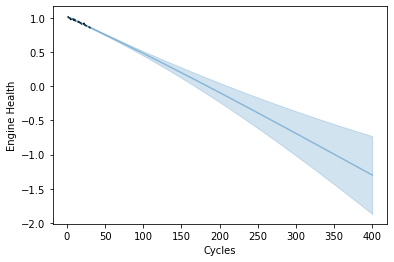

result [184.]
actual 143
lower band [166.]
upper band [207.]
2


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: C

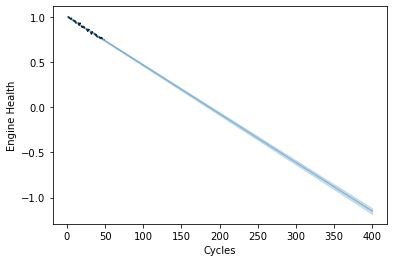

result [186.]
actual 147
lower band [184.]
upper band [190.]
3


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


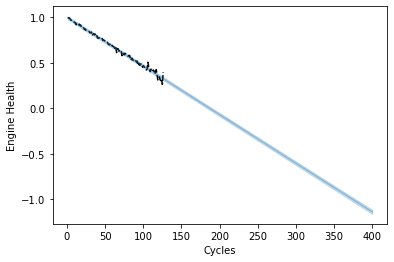

result [187.]
actual 195
lower band [184.]
upper band [191.]
4


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


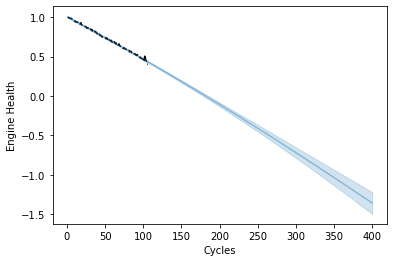

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


result [181.]
actual 188
lower band [179.]
upper band [186.]
5


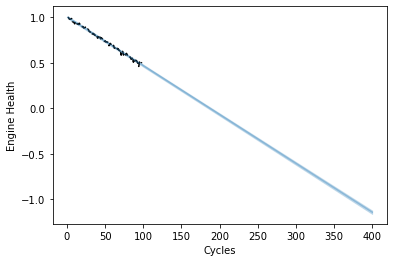

result [187.]
actual 189
lower band [185.]
upper band [190.]
6


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages

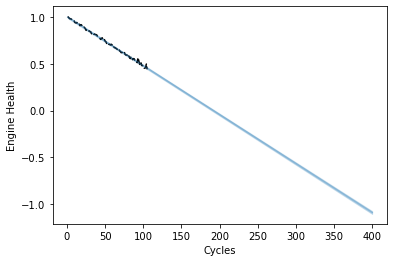

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


result [191.]
actual 198
lower band [190.]
upper band [194.]
7


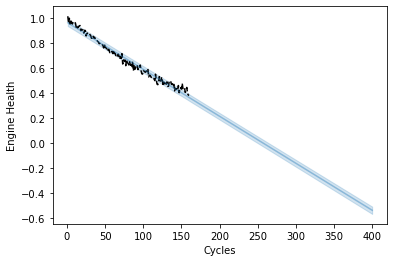

result [257.]
actual 251
lower band [251.]
upper band [265.]
8


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


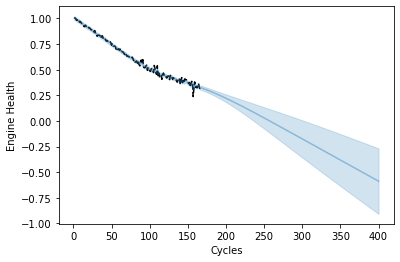

result [257.]
actual 261
lower band [235.]
upper band [294.]
9


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


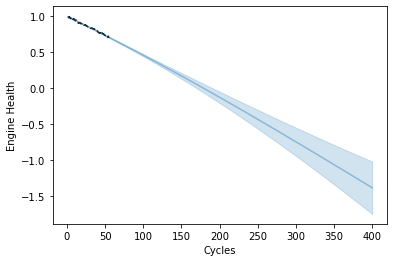

result [179.]
actual 166
lower band [170.]
upper band [191.]
10


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


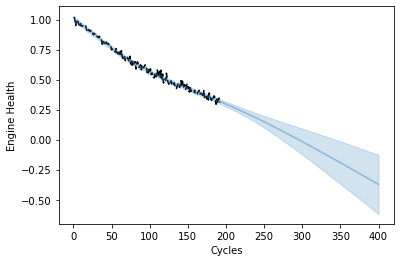

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


result [295.]
actual 288
lower band [272.]
upper band [334.]
11


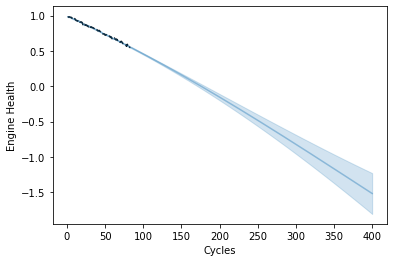

result [175.]
actual 180
lower band [171.]
upper band [182.]
12


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


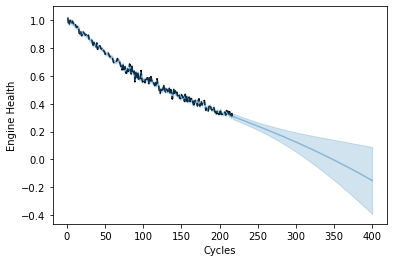

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [348.]
actual 341
lower band [313.]
13


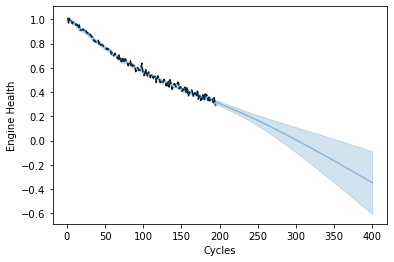

result [301.]
actual 290
lower band [278.]
upper band [345.]
14


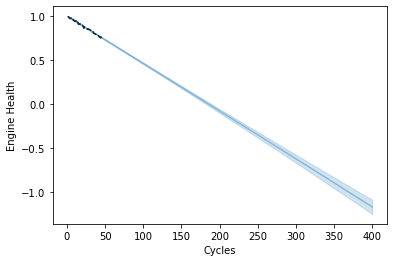

result [185.]
actual 153
lower band [183.]
upper band [190.]
15


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


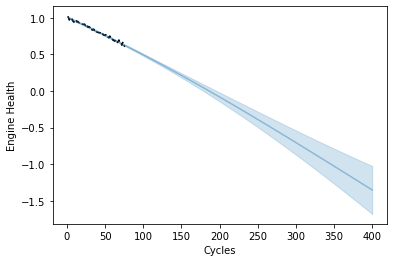

result [186.]
actual 159
lower band [179.]
upper band [196.]
16


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


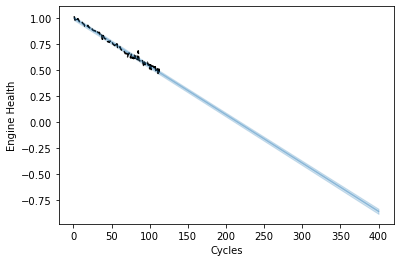

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [216.]
actual 197
lower band [212.]
upper band [221.]
17


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. De

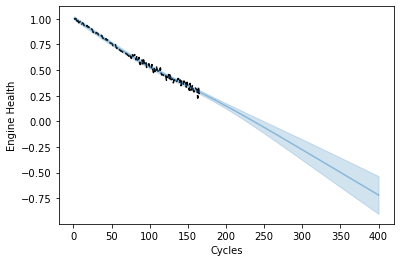

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [236.]
actual 215
lower band [227.]
upper band [250.]
18


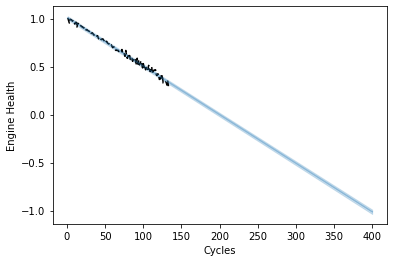

result [199.]
actual 161
lower band [197.]
upper band [204.]
19


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages

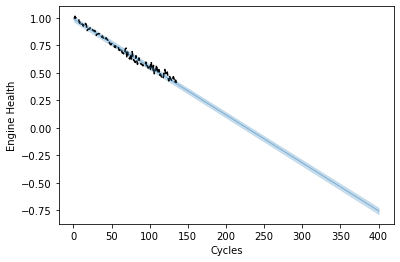

result [227.]
actual 222
lower band [222.]
upper band [233.]
20


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


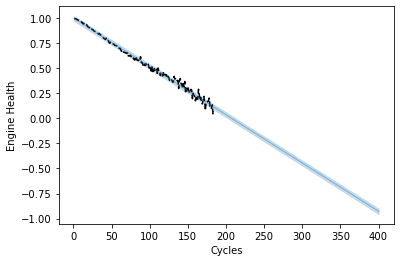

result [207.]
actual 200
lower band [203.]
upper band [213.]
21


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

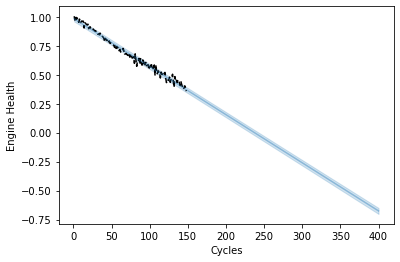

result [237.]
actual 205
lower band [232.]
upper band [243.]
22


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


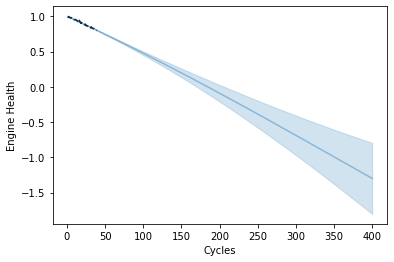

result [184.]
actual 150
lower band [169.]
upper band [204.]
23


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find 

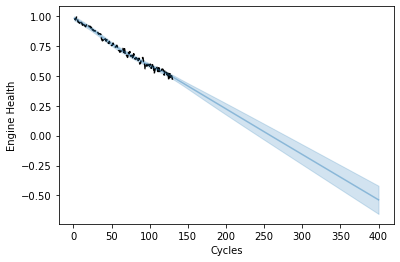

result [258.]
actual 243
lower band [241.]
upper band [278.]
24


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


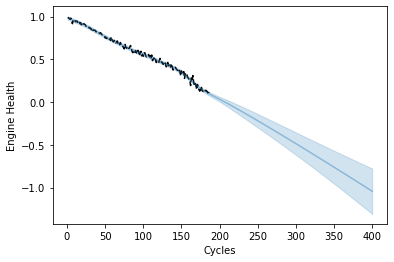

result [207.]
actual 206
lower band [201.]
upper band [217.]
25


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


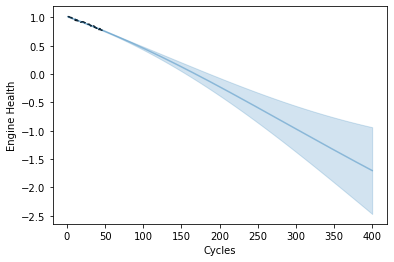

result [168.]
actual 193
lower band [156.]
upper band [185.]
26


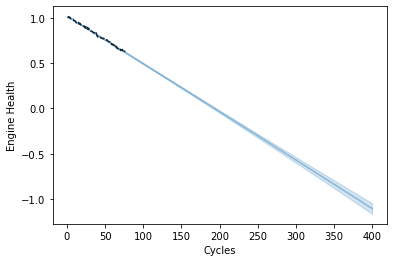

result [193.]
actual 195
lower band [191.]
upper band [196.]
27


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

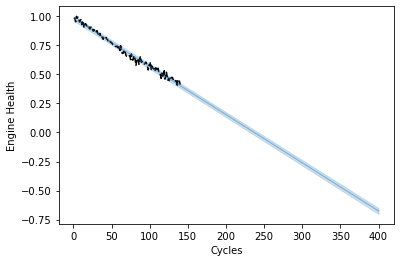

result [237.]
actual 206
lower band [232.]
upper band [243.]
28


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


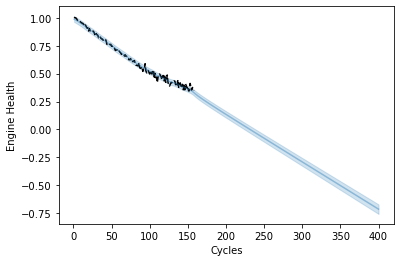

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [231.]
actual 255
lower band [225.]
upper band [239.]
29


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound 

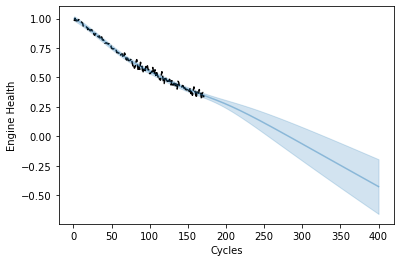

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [282.]
actual 261
lower band [254.]
upper band [322.]
30


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


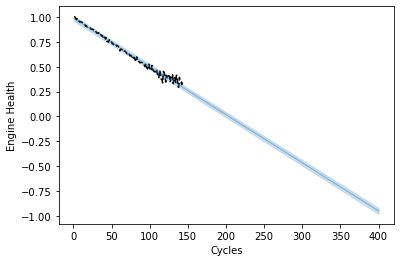

result [203.]
actual 258
lower band [199.]
upper band [209.]
31


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:310: RuntimeWarning: overflow encountered in exp
  params[hyperparameter.name] = np.exp(theta[i])
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


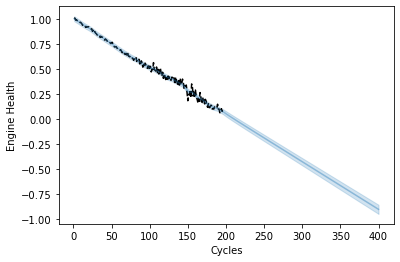

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [210.]
actual 204
lower band [205.]
upper band [217.]
32


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

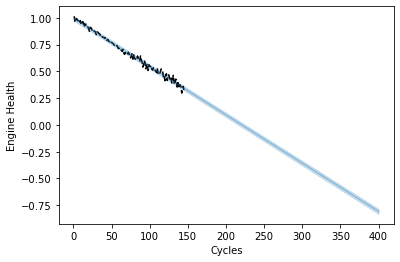

result [220.]
actual 193
lower band [217.]
upper band [226.]
33


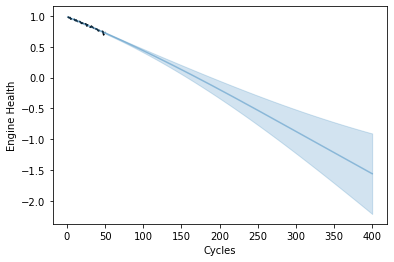

result [170.]
actual 156
lower band [157.]
upper band [188.]
34


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


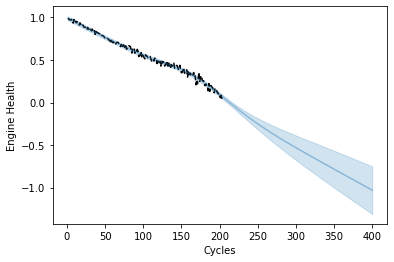

result [212.]
actual 210
lower band [210.]
upper band [217.]
35


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


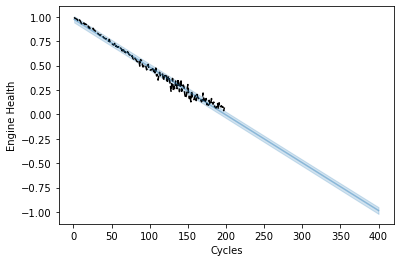

result [198.]
actual 209
lower band [193.]
upper band [206.]
36


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


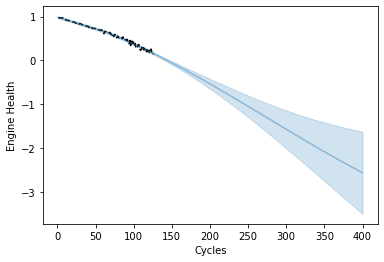

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [143.]
actual 145
lower band [141.]
upper band [148.]
37


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


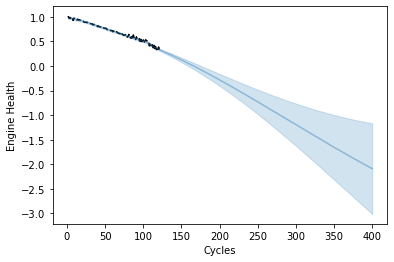

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [166.]
actual 142
lower band [159.]
upper band [176.]
38


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


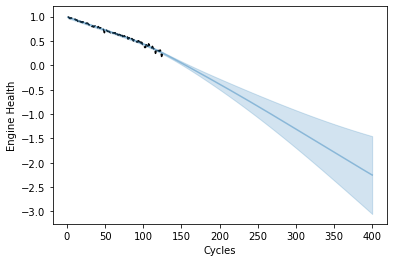

result [155.]
actual 175
lower band [152.]
upper band [161.]
39


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


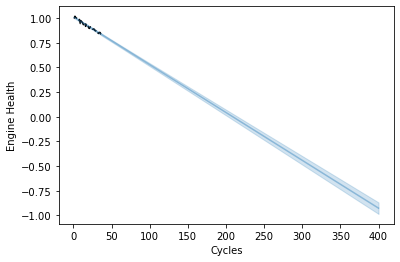

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [208.]
actual 179
lower band [203.]
upper band [216.]
40


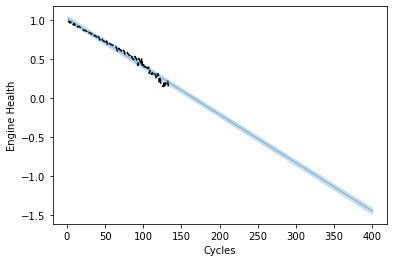

result [165.]
actual 161
lower band [161.]
upper band [171.]
41


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


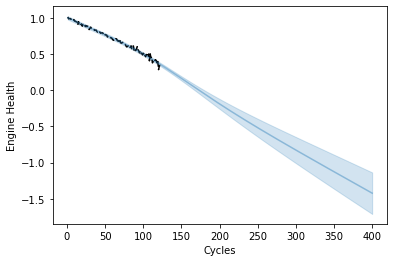

result [173.]
actual 141
lower band [168.]
upper band [180.]
42


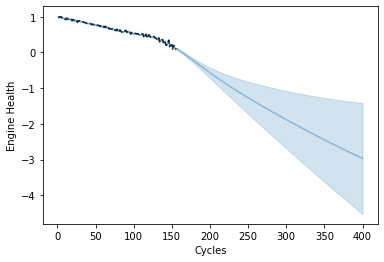

result [163.]
actual 166
lower band [162.]
upper band [166.]
43


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


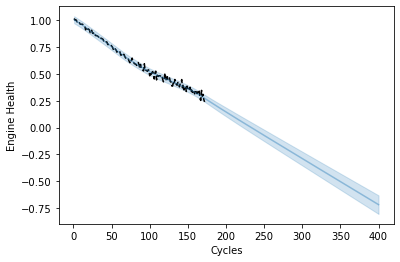

result [233.]
actual 231
lower band [223.]
upper band [245.]
44


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


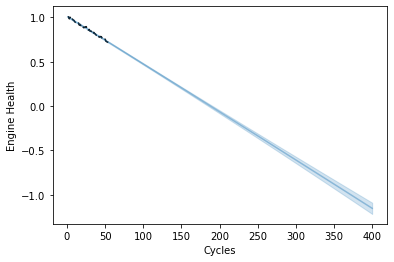

result [188.]
actual 163
lower band [186.]
upper band [192.]
45


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  war

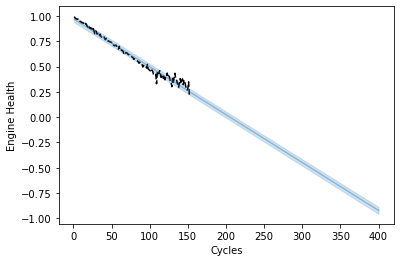

result [205.]
actual 266
lower band [199.]
upper band [212.]
46


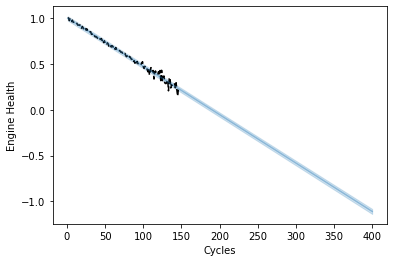

result [190.]
actual 193
lower band [186.]
upper band [195.]
47


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


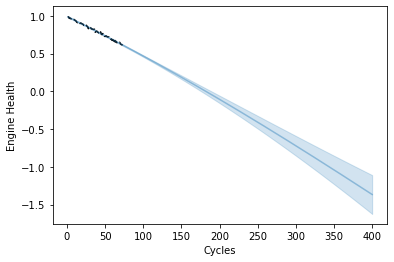

result [182.]
actual 208
lower band [176.]
upper band [190.]
48


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


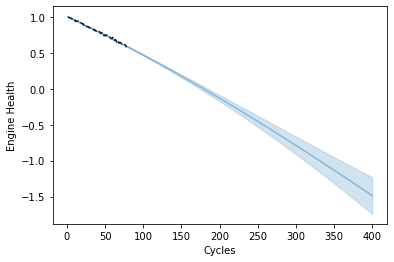

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [178.]
actual 170
lower band [174.]
upper band [185.]
49


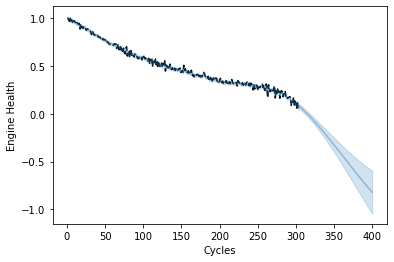

result [314.]
actual 324
lower band [312.]
upper band [319.]
50


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


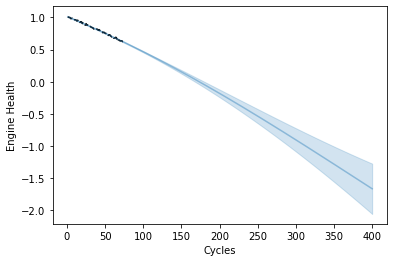

result [173.]
actual 153
lower band [168.]
upper band [180.]
51


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound 

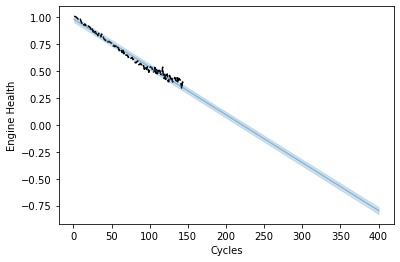

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [221.]
actual 258
lower band [215.]
upper band [228.]
52


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:310: RuntimeWarning: overflow encountered in exp
  params[hyperparameter.name] = np.exp(theta[i])


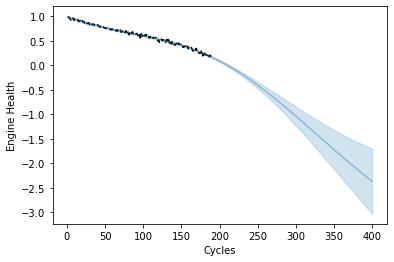

result [210.]
actual 218
lower band [208.]
upper band [214.]
53


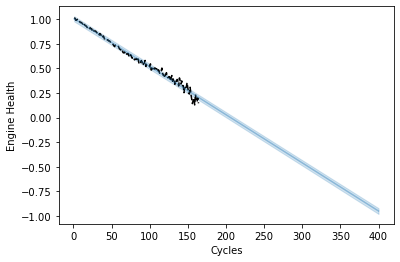

result [205.]
actual 190
lower band [201.]
upper band [212.]
54


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: Converge

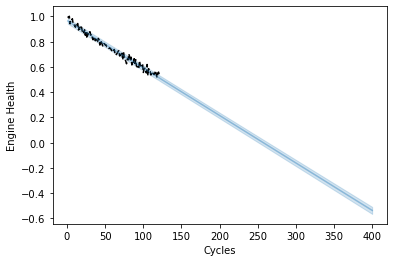

result [257.]
actual 218
lower band [251.]
upper band [264.]
55


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


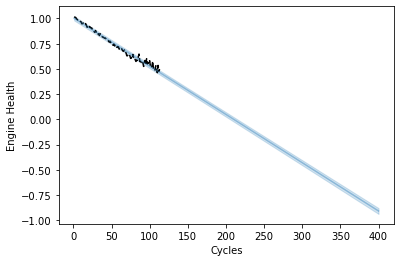

result [210.]
actual 250
lower band [206.]
upper band [215.]
56


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:310: RuntimeWarning: overflow encountered in exp
  params[hyperparameter.name] = np.exp(theta[i])


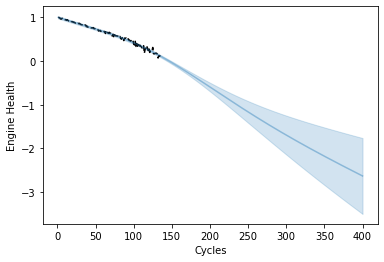

result [146.]
actual 151
lower band [144.]
upper band [149.]
57


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

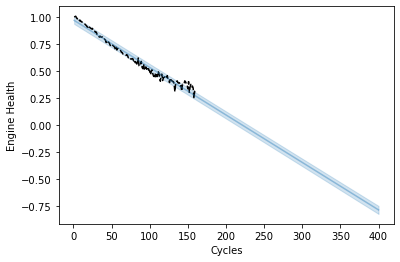

result [221.]
actual 263
lower band [214.]
upper band [229.]
58


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


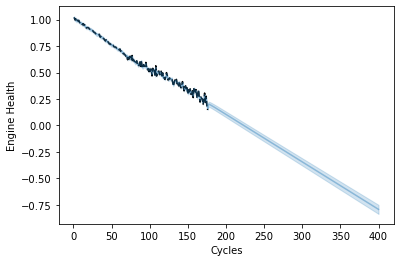

result [223.]
actual 213
lower band [217.]
upper band [230.]
59


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


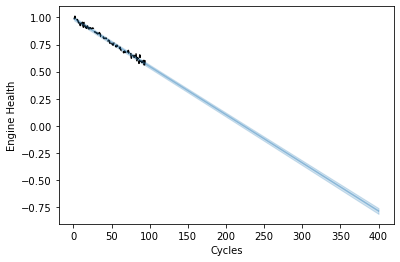

result [223.]
actual 208
lower band [219.]
upper band [228.]
60


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


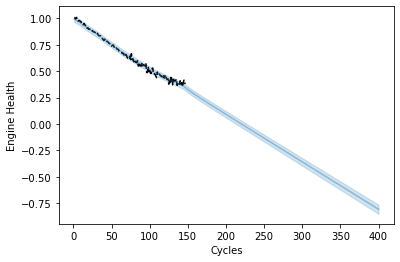

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [220.]
actual 247
lower band [213.]
upper band [228.]
61


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


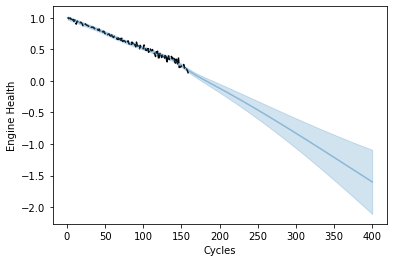

result [182.]
actual 180
lower band [176.]
upper band [191.]
62


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


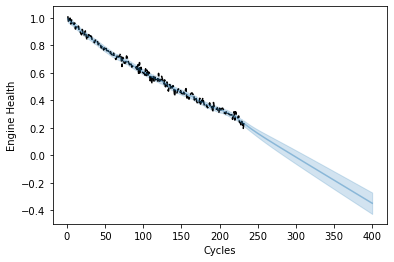

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [296.]
actual 286
lower band [283.]
upper band [312.]
63


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may f

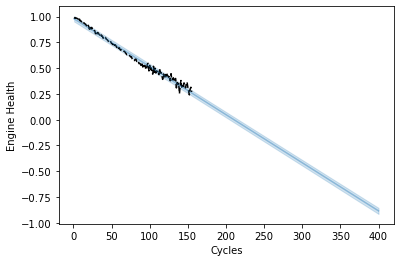

result [210.]
actual 227
lower band [205.]
upper band [216.]
64


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. De

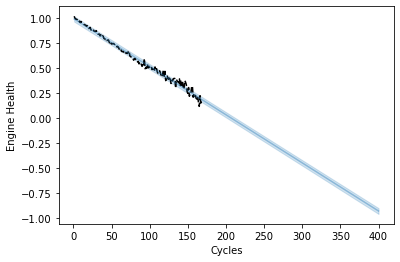

result [207.]
actual 196
lower band [202.]
upper band [213.]
65


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


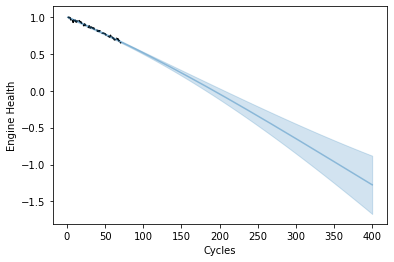

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [192.]
actual 199
lower band [182.]
upper band [206.]
66


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


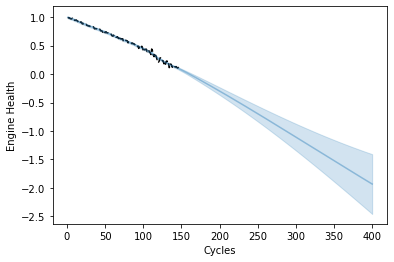

result [160.]
actual 161
lower band [157.]
upper band [165.]
67


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


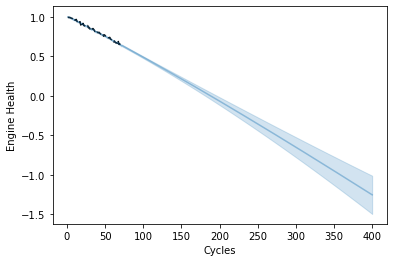

result [188.]
actual 148
lower band [182.]
upper band [197.]
68


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


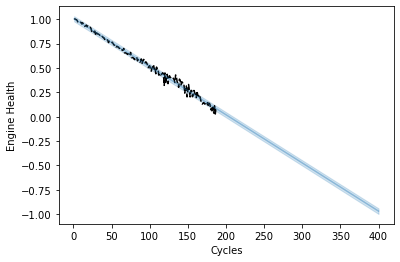

result [204.]
actual 195
lower band [199.]
upper band [210.]
69


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


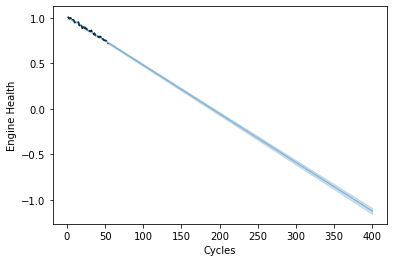

result [189.]
actual 175
lower band [187.]
upper band [193.]
70


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


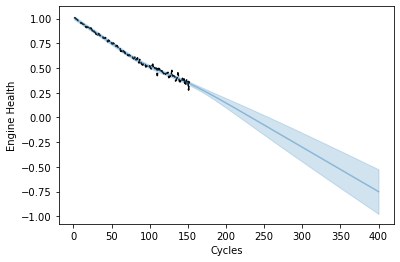

result [232.]
actual 246
lower band [218.]
upper band [254.]
71


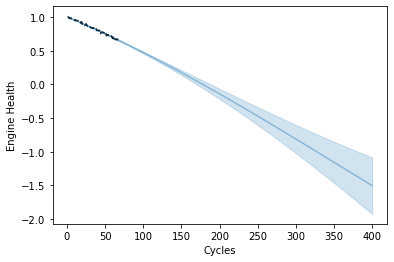

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [178.]
actual 186
lower band [170.]
upper band [188.]
72


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


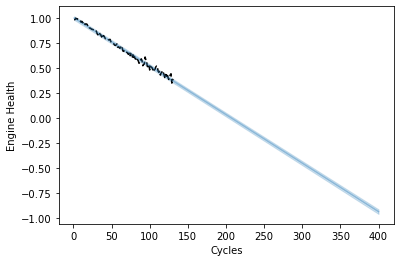

result [207.]
actual 181
lower band [204.]
upper band [212.]
73


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


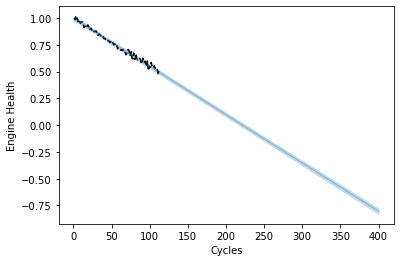

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [221.]
actual 243
lower band [218.]
upper band [226.]
74


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bo

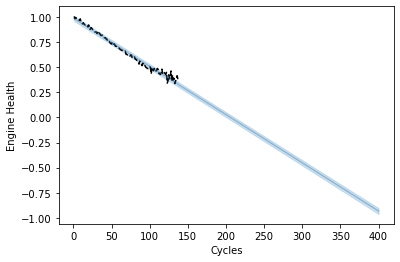

result [205.]
actual 263
lower band [201.]
upper band [211.]
75


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


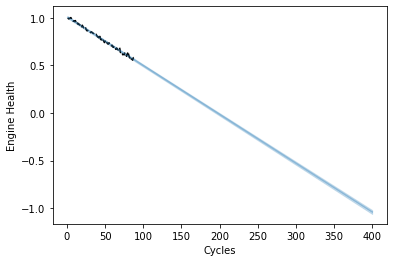

result [197.]
actual 201
lower band [195.]
upper band [200.]
76


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


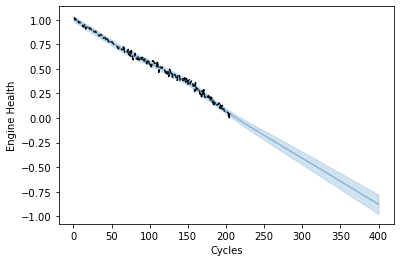

result [213.]
actual 215
lower band [208.]
upper band [220.]
77


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


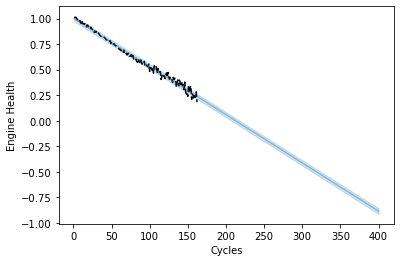

result [212.]
actual 196
lower band [208.]
upper band [218.]
78


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


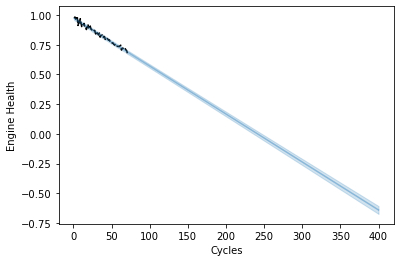

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [241.]
actual 179
lower band [236.]
upper band [247.]
79


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may f

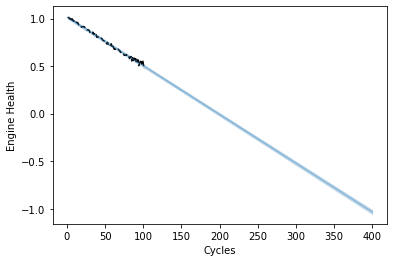

result [198.]
actual 164
lower band [196.]
upper band [202.]
80


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


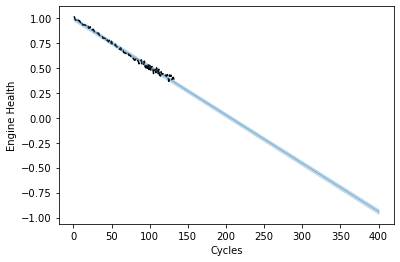

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [205.]
actual 223
lower band [202.]
upper band [210.]
81


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound 

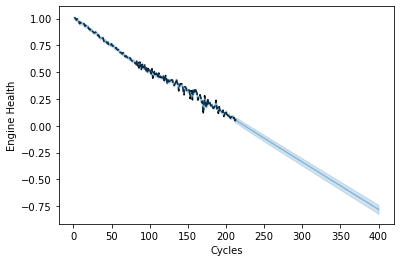

result [224.]
actual 221
lower band [219.]
upper band [231.]
82


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


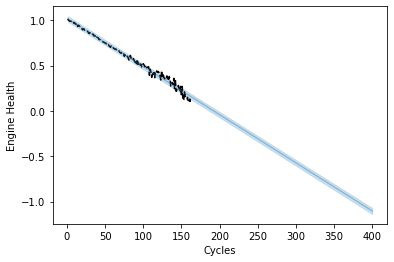

result [192.]
actual 171
lower band [187.]
upper band [198.]
83


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


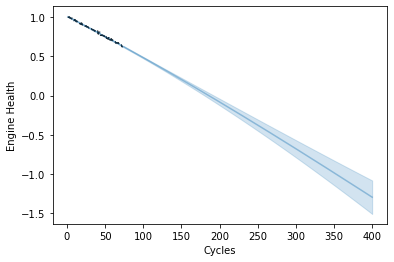

result [185.]
actual 210
lower band [180.]
upper band [193.]
84


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


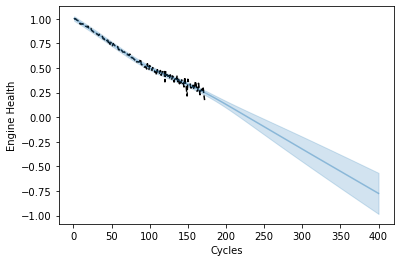

result [228.]
actual 230
lower band [218.]
upper band [244.]
85


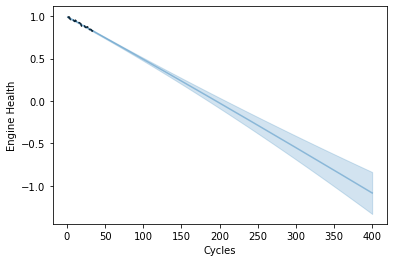

result [195.]
actual 152
lower band [185.]
upper band [208.]
86


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


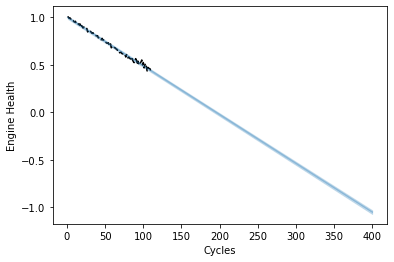

result [195.]
actual 199
lower band [193.]
upper band [199.]
87


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


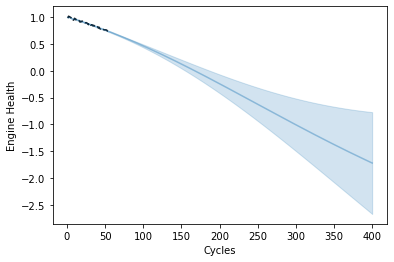

result [167.]
actual 172
lower band [155.]
upper band [185.]
88


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


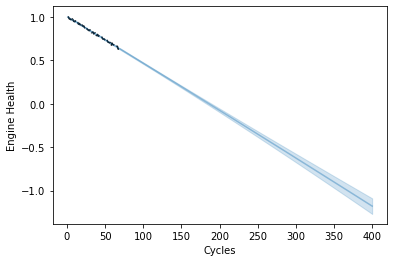

result [186.]
actual 183
lower band [183.]
upper band [190.]
89


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


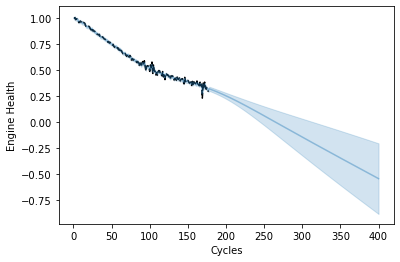

result [264.]
actual 313
lower band [243.]
upper band [302.]
90


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


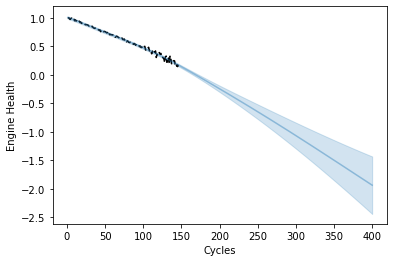

result [168.]
actual 174
lower band [165.]
upper band [173.]
91


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


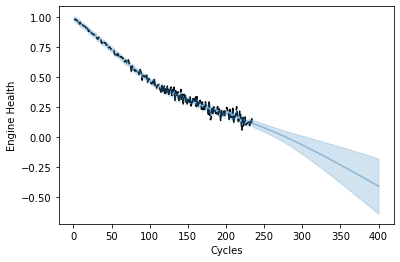

result [277.]
actual 272
lower band [264.]
upper band [303.]
92


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


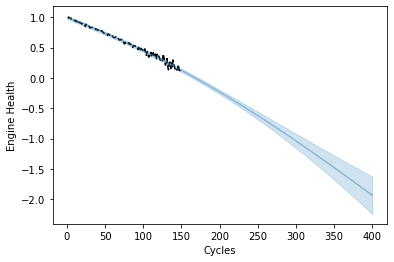

result [168.]
actual 170
lower band [164.]
upper band [173.]
93


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


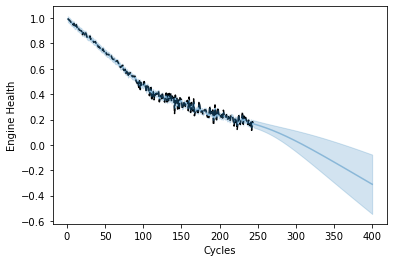

/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


result [309.]
actual 329
lower band [287.]
94


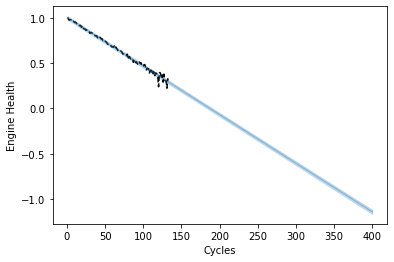

result [187.]
actual 188
lower band [184.]
upper band [191.]
95


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


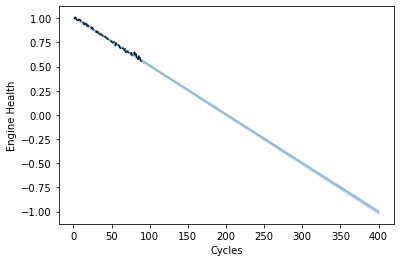

result [201.]
actual 217
lower band [199.]
upper band [204.]
96


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kerne

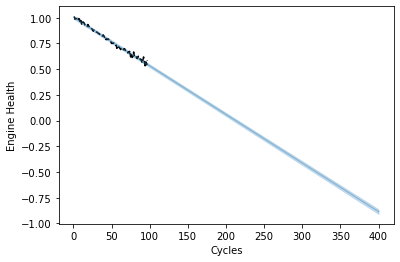

result [212.]
actual 234
lower band [210.]
upper band [217.]
97


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


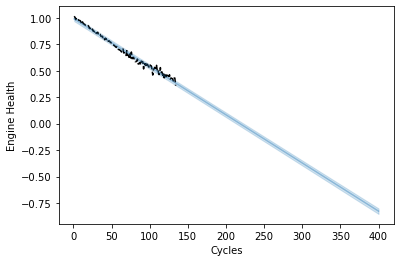

result [218.]
actual 216
lower band [214.]
upper band [224.]
98


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha


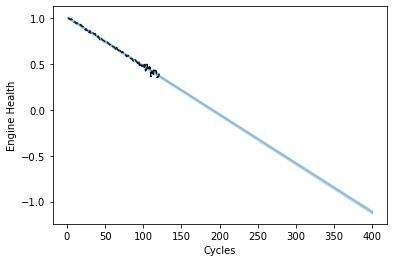

result [190.]
actual 180
lower band [188.]
upper band [194.]
99


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base**-self.alpha
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages

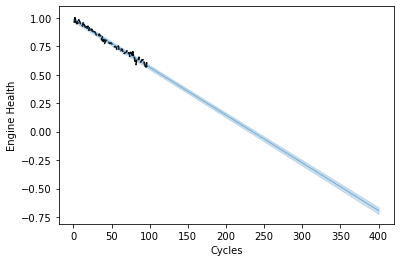

result [234.]
actual 214
lower band [230.]
upper band [240.]
100


/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sohanangelo/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bo

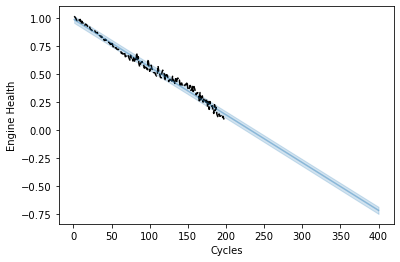

result [232.]
actual 218
lower band [226.]
upper band [240.]


In [456]:
#rul prediction is executed
results=np.zeros((100,1))
truncate=np.zeros((100,1))
for j in range(1,101):
    print(j)
    X_test = np.linspace(1, 400, 400).reshape(-1,1)
    Y_train,X_train,truncate[j-1]=pred_test(j)

    Y_train=1-Y_train
    #Y_train=Y_train*100
    gaussian_process = GaussianProcessRegressor(kernel, normalize_y=False)
    Y_mean=Y_train.mean()
    X_train=X_train.reshape(-1,1)
    gaussian_process.fit(X_train,Y_train)
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    plt.plot(X_train, Y_train, color="black", linestyle="dashed", label="Measurements")
    plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
    plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
    )
    plt.xlabel("Cycles")
    plt.ylabel("Engine Health")

    plt.show()
    for i in range(349):
        if (mean_y_pred[i]*mean_y_pred[i+1]<0):
            print("result",X_test[i])
            print("actual",rul[2][j-1])
            
            results[j-1]=X_test[i]
            break
    for i in range(349):
        if (mean_y_pred[i]- std_y_pred[i]*mean_y_pred[i+1]- std_y_pred[i+1]<0):
            print("lower band",X_test[i])
            #results[j-1]=X_test[i]
            break
            
    for i in range(349):
        if (mean_y_pred[i]+ std_y_pred[i]*mean_y_pred[i+1]+ std_y_pred[i+1]<0):
            print("upper band",X_test[i])
            #results[j-1]=X_test[i]
            break

In [457]:
rul1 = pd.read_csv("RUL_FD001.txt", sep=" ",header=None)

In [458]:
count=0
for i in results:
    #print(i)
    if i==0:
        count=count+1
print(count)        

0


In [459]:
rul1[1]=results
rul1[2]=truncate
rul1[3]=rul1[0]+rul1[2]#final RUL
rul1[4]=rul1[3]-rul1[1]#error

In [460]:
rul1 = rul1[(rul1[[1]] != 0).all(axis=1)]


In [461]:
print(rul1)

      0      1      2      3     4
0   112  184.0   31.0  143.0 -41.0
1    98  186.0   49.0  147.0 -39.0
2    69  187.0  126.0  195.0   8.0
3    82  181.0  106.0  188.0   7.0
4    91  187.0   98.0  189.0   2.0
..  ...    ...    ...    ...   ...
95  137  212.0   97.0  234.0  22.0
96   82  218.0  134.0  216.0  -2.0
97   59  190.0  121.0  180.0 -10.0
98  117  234.0   97.0  214.0 -20.0
99   20  232.0  198.0  218.0 -14.0

[100 rows x 5 columns]


In [462]:
error=rul1.pop(4)


In [463]:
er=error.to_numpy()


In [464]:
ersq=0
for i in range(100):
    print(i+1,er[i],"  ",rul1.iloc[i, 2])
    ersq=ersq+(er[i])**2

1 -41.0    31.0
2 -39.0    49.0
3 8.0    126.0
4 7.0    106.0
5 2.0    98.0
6 7.0    105.0
7 -6.0    160.0
8 4.0    166.0
9 -13.0    55.0
10 -7.0    192.0
11 5.0    83.0
12 -7.0    217.0
13 -11.0    195.0
14 -32.0    46.0
15 -27.0    76.0
16 -19.0    113.0
17 -21.0    165.0
18 -38.0    133.0
19 -5.0    135.0
20 -7.0    184.0
21 -32.0    148.0
22 -34.0    39.0
23 -15.0    130.0
24 -1.0    186.0
25 25.0    48.0
26 2.0    76.0
27 -31.0    140.0
28 24.0    158.0
29 -21.0    171.0
30 55.0    143.0
31 -6.0    196.0
32 -27.0    145.0
33 -14.0    50.0
34 -2.0    203.0
35 11.0    198.0
36 2.0    126.0
37 -24.0    121.0
38 20.0    125.0
39 -29.0    37.0
40 -4.0    133.0
41 -32.0    123.0
42 3.0    156.0
43 -2.0    172.0
44 -25.0    54.0
45 61.0    152.0
46 3.0    146.0
47 26.0    73.0
48 -8.0    78.0
49 10.0    303.0
50 -20.0    74.0
51 37.0    144.0
52 8.0    189.0
53 -15.0    164.0
54 -39.0    121.0
55 40.0    113.0
56 5.0    136.0
57 42.0    160.0
58 -10.0    176.0
59 -15.0    94.0
60 27.0   

In [465]:
mse=(ersq/i)**0.5

In [466]:
#mean square error in final output(numer of cycles prediction deviates by)
print(mse)

23.188076002266094
